
Found 12400 images belonging to 9 classes.
Found 2182 images belonging to 9 classes.
Class weights: {0: 3.8810641627543037, 1: 3.9365079365079363, 2: 0.5095332018408941, 3: 4.767397154940408, 4: 3.13844596304733, 5: 4.360056258790436, 6: 1.3682003751517158, 7: 0.5885424082775642, 8: 0.2995820347418521}



--- Starting Feature Extraction Training ---

Epoch 1/10


388/388 [==============================] - ETA: 0s - loss: 1.4559 - accuracy: 0.4319

C:\Users\rohit\projects\smart_farming\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


388/388 [==============================] - 628s 2s/step - loss: 1.4559 - accuracy: 0.4319 - val_loss: 0.9818 - val_accuracy: 0.6787 - lr: 0.0010
Epoch 2/10
388/388 [==============================] - 619s 2s/step - loss: 1.0131 - accuracy: 0.5666 - val_loss: 0.8757 - val_accuracy: 0.7122 - lr: 0.0010
Epoch 3/10
388/388 [==============================] - 627s 2s/step - loss: 0.9268 - accuracy: 0.6069 - val_loss: 0.9279 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 4/10
388/388 [==============================] - 619s 2s/step - loss: 0.8669 - accuracy: 0.6210 - val_loss: 0.8132 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 5/10
388/388 [==============================] - 622s 2s/step - loss: 0.8329 - accuracy: 0.6377 - val_loss: 0.8758 - val_accuracy: 0.7026 - lr: 0.0010
Epoch 6/10
388/388 [==============================] - 617s 2s/step - loss: 0.8022 - accuracy: 0.6431 - val_loss: 0.8137 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 7/10
388/388 [==============================] - 621s 2s/step - loss: 

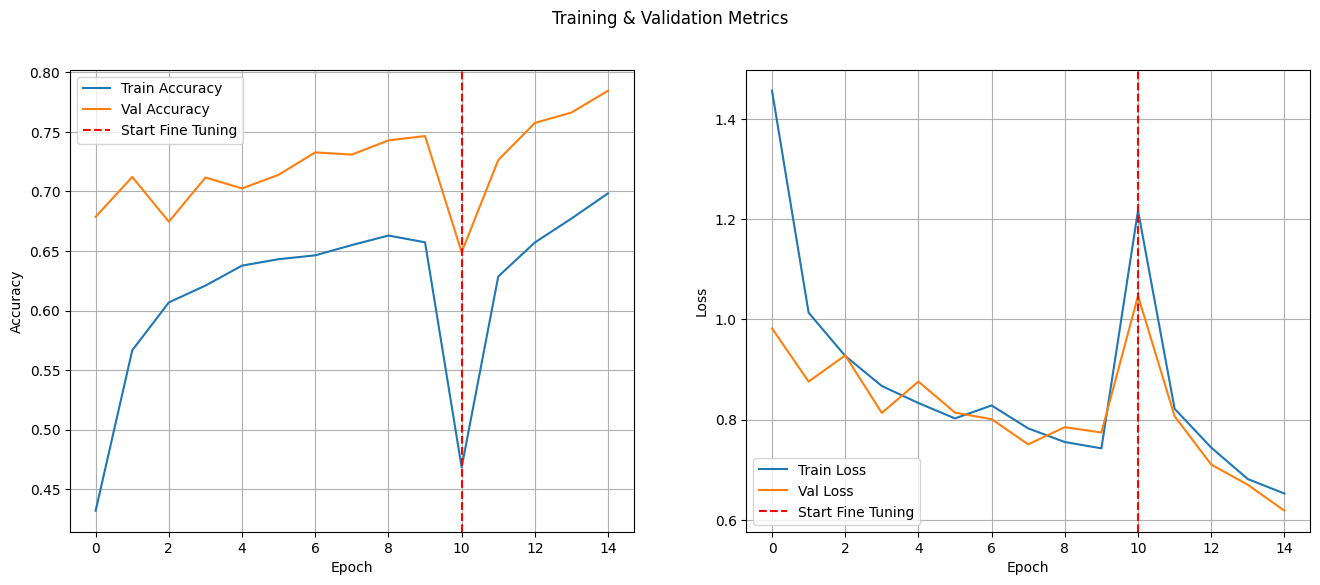

69/69 [==============================] - 111s 2s/step - loss: 0.6395 - accuracy: 0.7773
Validation Loss: 0.6395 | Validation Accuracy: 0.7773
69/69 [==============================] - 106s 2s/step


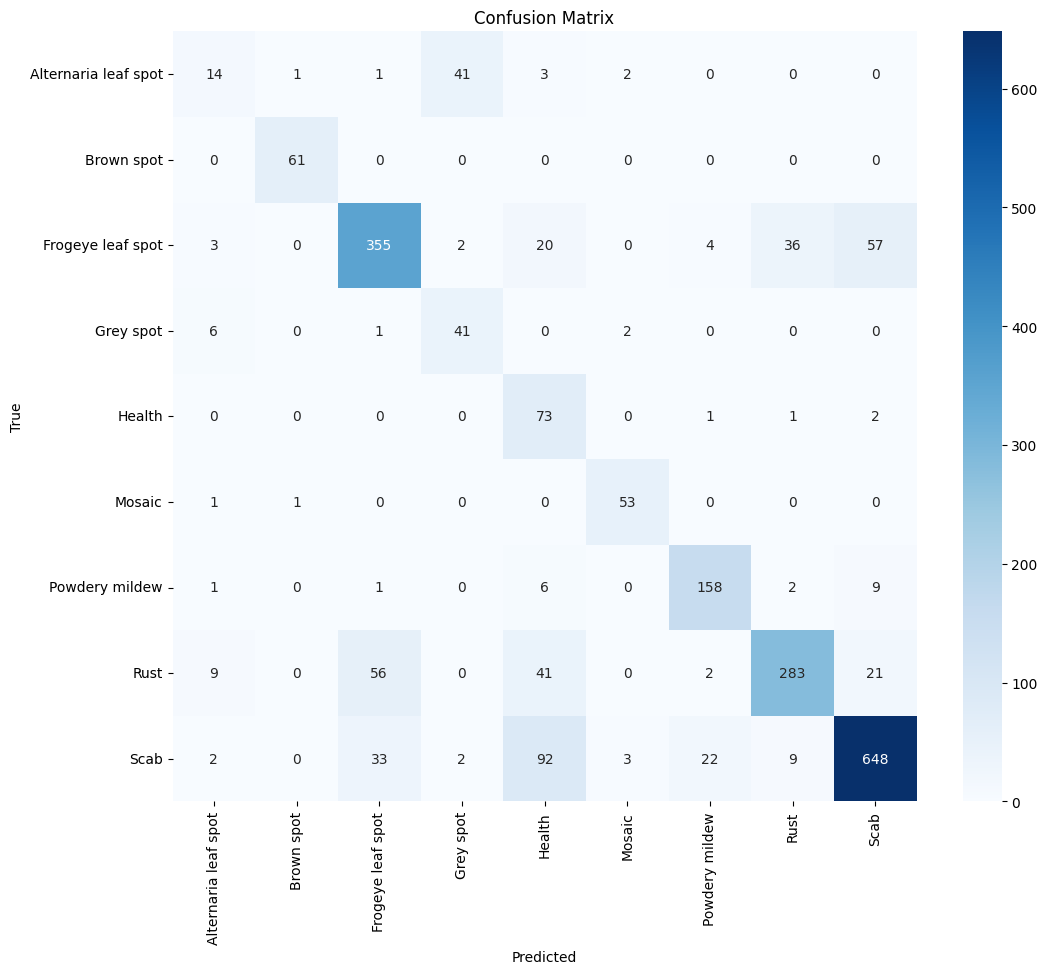


Classification Report:

                      precision    recall  f1-score   support

Alternaria leaf spot       0.39      0.23      0.29        62
          Brown spot       0.97      1.00      0.98        61
   Frogeye leaf spot       0.79      0.74      0.77       477
           Grey spot       0.48      0.82      0.60        50
              Health       0.31      0.95      0.47        77
              Mosaic       0.88      0.96      0.92        55
      Powdery mildew       0.84      0.89      0.87       177
                Rust       0.85      0.69      0.76       412
                Scab       0.88      0.80      0.84       811

            accuracy                           0.77      2182
           macro avg       0.71      0.79      0.72      2182
        weighted avg       0.81      0.77      0.78      2182



In [1]:
# 2_model_training.ipynb
# Using CNN model

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ============================
# Paths & Hyperparameters
# ============================
dataset_dir = '../data/disease_detection/raw/AppleLeaf/'
model_save_path = '../models/apple_leaf_cnn_model.h5'
os.makedirs('models', exist_ok=True)
os.makedirs('outputs/figures', exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 10
FINE_TUNING_EPOCHS = 5
LEARNING_RATE = 1e-3
FINE_TUNING_LR = 1e-5

# ============================
# Data Augmentation & Loaders
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ============================
# Compute Class Weights
# ============================
try:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = dict(enumerate(class_weights))
    print("Class weights:", class_weights)
except Exception as e:
    print(f"Could not compute class weights: {e}")
    class_weights = None

# ============================
# Build MobileNetV2 Model
# ============================
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base model

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, base_model = build_model(train_generator.num_classes)

# ============================
# Callbacks for Training
# ============================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True)

# ============================
# Compile & Train Model (Phase 1)
# ============================
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Starting Feature Extraction Training ---\n")
initial_history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# ============================
# Fine-tune Base Model (Phase 2)
# ============================
print("\n--- Starting Fine Tuning ---\n")
base_model.trainable = True
for layer in base_model.layers[:-15]:  # Fine-tune last 15 layers only
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNING_LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS + FINE_TUNING_EPOCHS,
    initial_epoch=len(initial_history.history['loss']),
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# ============================
# Combine & Plot Training History
# ============================
history = {key: initial_history.history.get(key, []) + fine_tune_history.history.get(key, []) for key in initial_history.history.keys()}

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.axvline(x=INITIAL_EPOCHS, color='r', linestyle='--', label='Start Fine Tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.axvline(x=INITIAL_EPOCHS, color='r', linestyle='--', label='Start Fine Tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Training & Validation Metrics')
plt.savefig('outputs/figures/apple_disease_training_metrics.png', dpi=300)
plt.show()

# ============================
# Evaluate on Validation Set
# ============================
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

# ============================
# Confusion Matrix & Classification Report
# ============================
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('outputs/figures/confusion_matrix.png', dpi=300)
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))